<h1 style="text-align: center">Glass-Bangle-detection Using Resnet and GoogleNet</h1>

<h3 style="text-align:right">-By Aryan Gupta</h3>

In [1]:
%pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/almique/glass-bangle-defect-detection-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aryagup
Your Kaggle Key: ··········


100%|██████████| 1.31G/1.31G [00:08<00:00, 158MB/s]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import splitfolders
import matplotlib.pyplot as plt

In [6]:
input_folder = "/content/glass-bangle-defect-detection-classification/dataset/"
output = "/content/split-dataset1" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 1080 files [00:05, 209.24 files/s]


# Data-Preprocessing and Normalisation

In [9]:

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content/split-dataset1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(class_names)

['broken', 'defect', 'good']


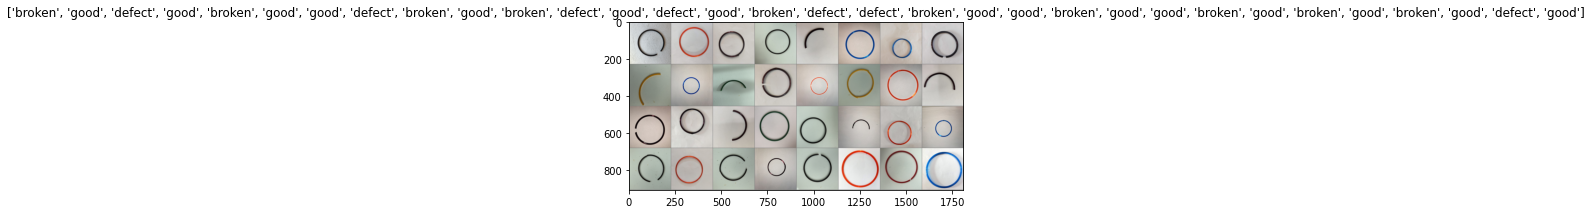

In [10]:

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
device

device(type='cuda')

In [31]:
train_error_list = []
train_accuracy_list = []
val_error_list = []
val_accuracy_list = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_error_list.append(epoch_loss)
                train_accuracy_list.append(epoch_acc)
            if phase == 'val':
                val_error_list.append(epoch_loss)
                val_accuracy_list.append(epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Resnet

In [13]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=6)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/5
----------
train Loss: 0.9580 Acc: 0.5504
val Loss: 0.7653 Acc: 0.7281

Epoch 1/5
----------
train Loss: 0.7195 Acc: 0.7439
val Loss: 0.6078 Acc: 0.8065

Epoch 2/5
----------
train Loss: 0.5812 Acc: 0.8239
val Loss: 0.5340 Acc: 0.8479

Epoch 3/5
----------
train Loss: 0.5127 Acc: 0.8343
val Loss: 0.4566 Acc: 0.8802

Epoch 4/5
----------
train Loss: 0.4569 Acc: 0.8575
val Loss: 0.4212 Acc: 0.8986

Epoch 5/5
----------
train Loss: 0.4184 Acc: 0.8621
val Loss: 0.3902 Acc: 0.8848

Training complete in 19m 31s
Best val Acc: 0.898618


In [ ]:
train_accuracy_list = [(x.cpu().numpy()) for x in train_accuracy_list]

In [28]:
val_accuracy_list = [(x.cpu().numpy()) for x in val_accuracy_list]

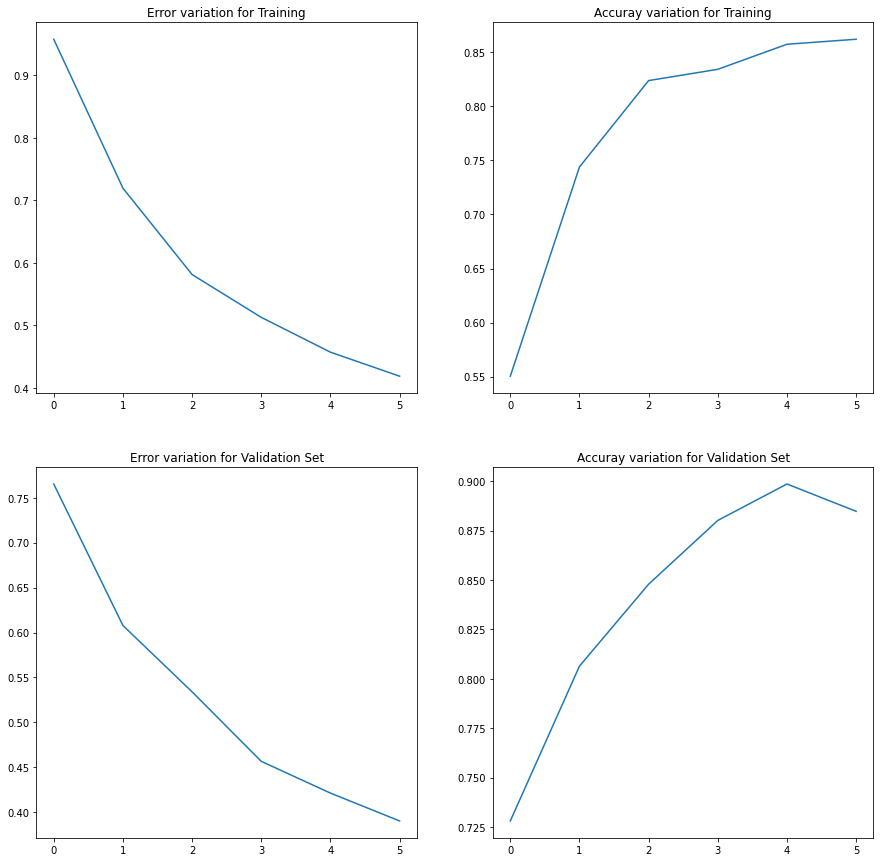

In [29]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 15))
  
# For train error
axis[0, 0].plot([x for x in range(len(train_error_list))], train_error_list)
axis[0, 0].set_title("Error variation for Training")
# For train accuracy
axis[0, 1].plot([x for x in range(len(train_accuracy_list))], train_accuracy_list)
axis[0, 1].set_title("Accuray variation for Training")
# For validation error
axis[1, 0].plot([x for x in range(len(val_error_list))], val_error_list)
axis[1, 0].set_title("Error variation for Validation Set")
# For validation accuracy
axis[1, 1].plot([x for x in range(len(val_accuracy_list))], val_accuracy_list)
axis[1, 1].set_title("Accuray variation for Validation Set")
plt.show()

## GoogleNet

In [34]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=6)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Epoch 0/5
----------
train Loss: 0.9866 Acc: 0.5643
val Loss: 0.9518 Acc: 0.5622

Epoch 1/5
----------
train Loss: 0.9255 Acc: 0.5921
val Loss: 0.8891 Acc: 0.6498

Epoch 2/5
----------
train Loss: 0.8624 Acc: 0.6744
val Loss: 0.8322 Acc: 0.6866

Epoch 3/5
----------
train Loss: 0.8147 Acc: 0.7068
val Loss: 0.7855 Acc: 0.7189

Epoch 4/5
----------
train Loss: 0.7732 Acc: 0.7207
val Loss: 0.7501 Acc: 0.7051

Epoch 5/5
----------
train Loss: 0.7269 Acc: 0.7462
val Loss: 0.7118 Acc: 0.7788

Training complete in 19m 42s
Best val Acc: 0.778802


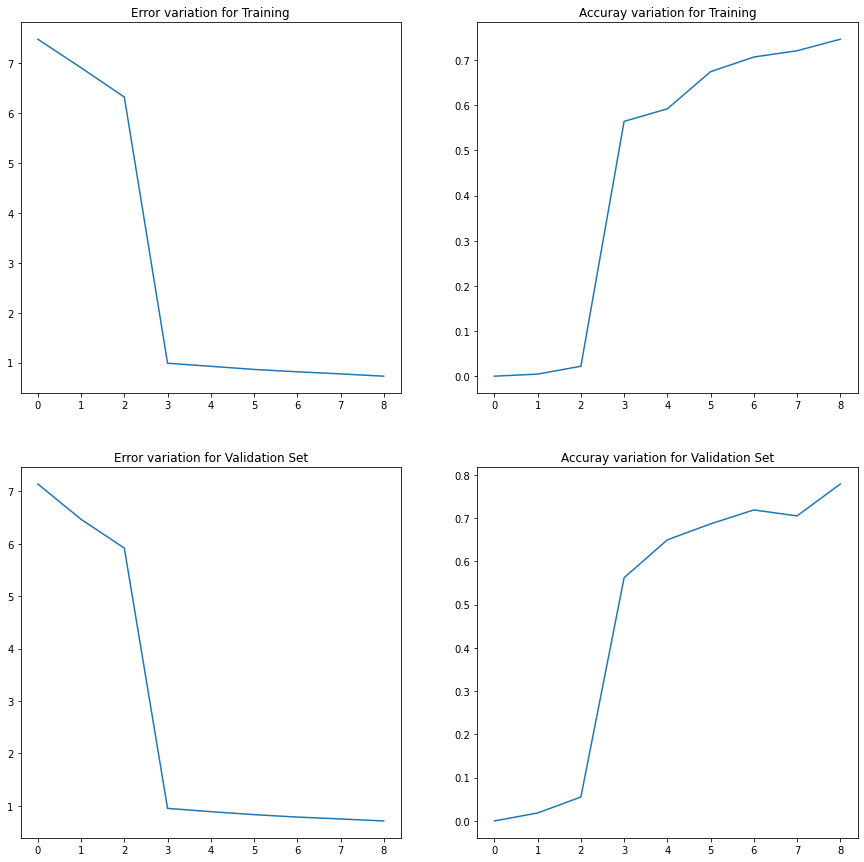

In [35]:
train_accuracy_list = [(x.cpu().numpy()) for x in train_accuracy_list]
val_accuracy_list = [(x.cpu().numpy()) for x in val_accuracy_list]
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 15))
  
# For training loss
axis[0, 0].plot([x for x in range(len(train_error_list))], train_error_list)
axis[0, 0].set_title("Error variation for Training")

# For training accuracy  
axis[0, 1].plot([x for x in range(len(train_accuracy_list))], train_accuracy_list)
axis[0, 1].set_title("Accuray variation for Training")

# For validation loss
axis[1, 0].plot([x for x in range(len(val_error_list))], val_error_list)
axis[1, 0].set_title("Error variation for Validation Set")
  
# For validation accuracy
axis[1, 1].plot([x for x in range(len(val_accuracy_list))], val_accuracy_list)
axis[1, 1].set_title("Accuray variation for Validation Set")
# Combine all the operations and display
plt.show()